# Tellurium Introduction:

## Motivation ... a minimal example!
Just a few lines of code allow a model to be loaded, simulated and plotted!

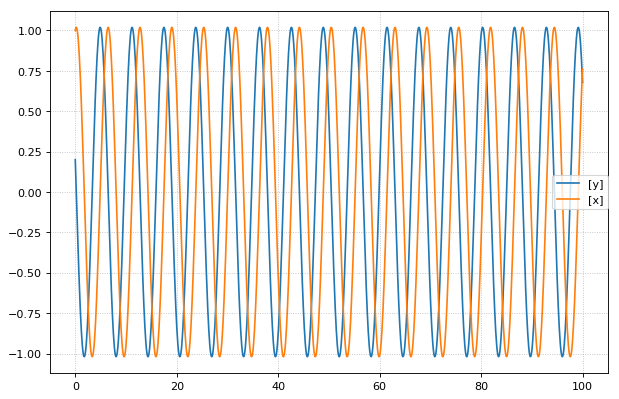

In [76]:
import tellurium as te
te.setDefaultPlottingEngine('matplotlib')
import matplotlib.pyplot as plt
%matplotlib inline
antimony_model = '''J0: -> y; -x;J1: -> x; y;x = 1.0;y = 0.2;'''
r = te.loada(antimony_model)
r.simulate(0,100,1000)
r.plot()

plt.show()

## Everything in a single tool - *tellurium*:

As you could see, *tellurium* allows you to create and manipulate a model in a pythonic way. The *tellurium* package consists of formerly two distinct packages: *antimony* which is a modeling-language and *roadrunner* a sbml-simulator. The main advantage of tellurium is how both work together in python: as soon as you load a model a roadrunner simulator will be instanciated simultaniously. This way your model and the solver are a python object - the *same* object!  This allows you to have real power over your model and the solver and control everything within your python script. 

For further reading:

Full documentation
http://tellurium.readthedocs.io/en/latest/index.html

Short documentation
http://tellurium.analogmachine.org/documentation/antimony-documentation

Antimony (bio-)models library
http://antimony.sourceforge.net/antimony-biomodels.html

## The tellurium course will cover these topics:

### 1. Antimony as a modeling language

    - important bits of a model
        Compartments
        Species
        Reactions
        Events
    - specialities of the syntax
    - relation to SBML
    - modules
    
### 2. Tellurium 

    - general use of models (import/export/conversion)
    - model as a python object (model accession)
    - reset a model and set time-course-selections 
    - Draw a graph: model in network representation
    - LaTex output: model in ODE representation (not implemented; Sbml2Latex: broken due to up-to-date sbml level)    

### 3. Roadrunner 
    
    - solvers and solver settings
    - stochastic simulations, set seeds
    - steady-state analysis (broken due to up-to-date sbml level)

### 4. Customized workflow

    - plotting: timecourses, phase portrait
    - old school event handling: sim - event - sim
    - parameter scan
    - bifurcation analysis
    - control coefficients   
    
    

## Tutorial Part I - Create a Model :

Let us start from scratch and define a new model (if you execute the next cell then tellurium tries to load your model and performs a basic syntax check at the same time!):

In [77]:
import tellurium as te

model = ''''''

model_backup = '''
model example
    # UNITS:
    #

    #unit alienliters = 0.123 liters
    #unit fL = 1.e-15 liters

    # COMPARTMENTS:
    #

    compartment cell = 100;
    compartment mitochondria = 10;
    mitochondria in cell;

    #mitochondria has fL;
    #cell has fL;

    # INITIAL VALUES
    #

    TOM1 = 10;
    A_c = 100;
    A_m = 1;
    I = 1;

    TOM1 in cell;
    A_c in cell;
    A_m in mitochondria;
    I in cell;

    # REACTIONS
    #


    T0: A_c + TOM1 -> 2 A_m + TOM1; kineticLaw;
    kineticLaw := k1 * TOM1 * (A_c - A_m)/I

    k1 = 0.01

    # EVENTS:

    #E1: at (A_c < 50): k1 = 0;
    #E2: at (time>300): TOM1 = 20, A_c = 120;
end

'''

r = te.loada(model)

def aa(line, cell):
    global model
    #print line,cell
    model = model + str(cell) + "\n"
    te.loada(str(model))
get_ipython().register_magic_function(aa, "cell")     

Antimony is a language that is analog to **SBML** Systems Biology Markup Language but human-readable. Therefore the concepts that are present in SBML can be found in antimony too. The definition of a **compartment** is such a SB concept!

### Step 1: Define a compartment!

In [78]:
%%aa # %%aa: A-ppend to A-ntimony model, only for educational purpose!
compartment cell = 100;

Ok... But that's just boring. Let's define something truly special and add a second compartment which is located in your previous one:

In [79]:
%%aa
compartment mitochondria;
mitochondria = 10;
mitochondria in cell;

Awesome! But be aware... circular definitions are not allowed.
Something like this won't work:

> comp_a in comp_b; comp_b in comp_c; comp_c in comp_a;


SBML has a system of unit definition. But the numbers we assigned to the compartments are without any specified unit at the moment. It is good practice to always use units and it is possible to define custom units!

In [80]:
%%aa
unit alienliters = 0.123 liters
unit fL = 1.e-15 liters

To specify units you can write the value and the unit combined in the same line:

In [81]:
%%aa
mitochondria = 10 fL;

Or simply change the units:

In [82]:
%%aa
mitochondria has fL;

### Step 2: Define some species.

In [83]:
%%aa
TOM1 = 10;
A_c = 100;
A_m = 1;

Smart! You already initialized your species. But you forgot to specify the location of your species! Add these lines:

In [84]:
%%aa
TOM1 in cell;
A_c in cell;
A_m in mitochondria;

### Step 3: Define reactions.

In [85]:
%%aa
T0: A_c + TOM1 -> A_m + TOM1; kineticLaw;
kineticLaw := k1 * TOM1 * (A_c - (A_m+0.01))
k1 = 0.01

### Syntax in antimony is subtile:

#### There are 3 (+1) important bits in a reaction:

0) The name of your reaction:
        
**name**: A + E -> B + 2C + E; kineticLaw;
    
    
i) The direction '**->**' (sets the sign in an ODE before the kineticLaw: plus or minus):
        
name: A + E **->** B + 2C + E; kineticLaw;
    
   
ii) The stoichiometry:

name: **A + E** -> **B + 2C + E**; kineticLaw;

iii) The kinetic law:

name: A + E -> B + 2C + E; **kineticLaw**;

The kinetic law is always in units of *amount/time*! This way it is consistent with stochastic simulations (you can directly run the 'gillespie'-algorithm in tellurium's solver: roadrunner) and furthermore any considerations regarding compartment sizes (even time depending compartment changes or transport reactions) are automatically done by the solver to get the correct concentrations for your species.

### About Assignments and ODE's: 

This " = " is a simple assignment, basically an initialization:


```
parameter = 5
species = 1
species2 = species + parameter
```

This " := " is a time-dependend assignment, the variable at the left will adapt, if the right hand side changes:


```
species0 := 3 * time
species1 := species0
```

This " '= " will create an ODE:

```
species'= k * species  
```

### Step 4: Events. 

You can define events, which may change values depending on boolean expressions...

In [86]:
%%aa
E1: at (A_c < 50): k1 = 0;

Or set a time dependend event. You may notice that *time* is special and the already predefined model time:

In [87]:
%%aa
E2: at (time>300): TOM1 = 20, A_c = 120;

Ok, now you may want to test your model and simulate it. You should definitly do this before we continue. Make sure that your model is correctly defined at the top of this jupyter notebook (you may execute the cell again!).
Then you can run it:

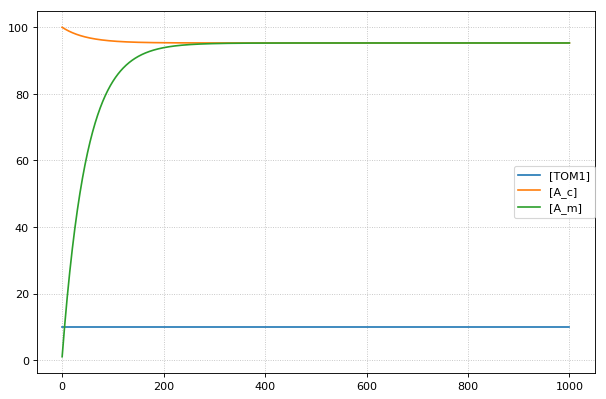

In [88]:
import tellurium as te
r = te.loada(model_backup)
r.simulate(0,1000,1000)
r.plot()

## Import/Export Models:

First, we need the tellurium package:

In [89]:
import tellurium as te

#### Load a model... You can choose from:


i) load a test model from tellurium itself.

In [90]:
print te.listTestModels()

['feedback.xml', 'linearPathwayClosed.xml', 'EcoliCore.xml', 'linearPathwayOpen.xml', 'test_1.xml']


In [91]:
#r_feedback = te.loadTestModel('feedback.xml')
#result = r_feedback.simulate()
#r_feedback.plot()

 ii) download 'curated BioModels translated to Antimony' from here http://antimony.sourceforge.net/antimony-biomodels.html:

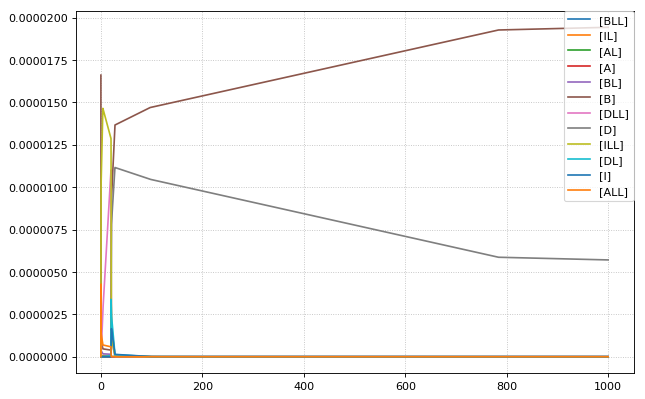

In [92]:
import urllib2
bio1 = urllib2.urlopen('http://antimony.sourceforge.net/examples/biomodels/BIOMD0000000001.txt').read()
r_bio1 = te.loadAntimonyModel(bio1)
r_bio1.simulate(0,1000,10000)
r_bio1.plot()

iii) load your own model:


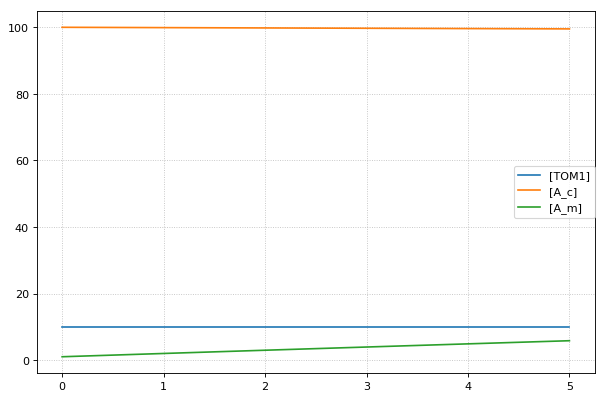

In [93]:
import tellurium as te
r = te.loada(model)
r.simulate()
r.plot()

You can also convert models between modeling-languages:

In [94]:
sbml_model = te.antimonyToSBML(model)

Then save the model in a file:

In [95]:
with open('model_backup.xml','wb') as f:
	f.write(sbml_model)
# directly for antimony:
with open('example.antimony','wb') as f:
	f.write(model_backup)

An read it again...

In [96]:
r_sbml_model = te.loadSBMLModel('model.xml')

You can also draw your model: 

In [97]:
#def draw(model):
#    diagram = te.visualization.SBMLDiagram(model.getSBML())
#    diagram.draw()
#draw(r)

## Parameter estimation

### Important concept: Reset a model!

> .reset() # reset species to initial values 

> .resetAll() # reset species + paramters

> .resetToOrigin() # similar to load the model

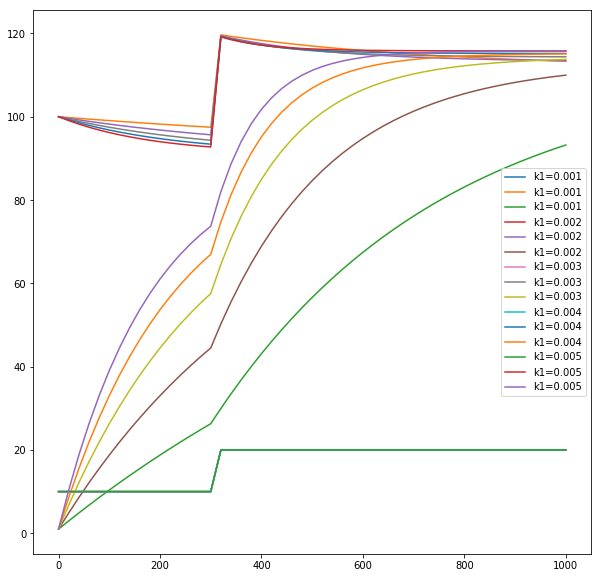

In [98]:
r = te.loada(model)

fig = plt.figure(figsize=(10,10))
for i in np.linspace(0.001,0.005,5):
    r.reset()
    r.k1 = i    
    #r.reset() # reset species to initial values
    #r.resetAll() # reset species + paramters
    #r.resetToOrigin() # similar to load the model
    r.integrator='cvode'
    result = r.simulate(0,1000)
    #plt.subplot(1,5,)    
    plt.plot(result[:,0],result[:,1:],label='k1=%s'%i)
    #r.plot(show=False,color = 'r')
    
plt.legend()
plt.show()

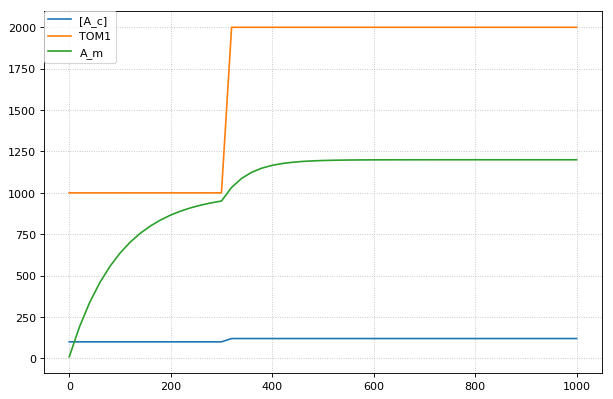

In [101]:
r = te.loada(model)
#print r.getAntimony()

model = '''
// Created by libAntimony v2.9.4
// Compartments and Species:
compartment cell, mitochondria;
species TOM1 in cell, A_c in cell, A_m in mitochondria;

// Assignment Rules:
kineticLaw := k1*TOM1*(A_c - (A_m + 0.01));

// Reactions:
T0: A_c + TOM1 -> A_m + TOM1; kineticLaw;

// Events:
E1: at A_c < 50: k1 = 0;
E2: at time > 300: TOM1 = 20, A_c = 120;

// Species initializations:
TOM1 = 10;
A_c = 100;
A_m = 1;

// Compartment initializations:
cell = 100;
mitochondria = 10;
mitochondria has fL;

// Variable initializations:
k1 = 0.01;

// Other declarations:
var k1, kineticLaw;
const cell, mitochondria;

// Unit definitions:
unit alienliter = 1.23e-1 litre;
unit fL = 1e-15 litre;

const A_c; 
'''
r = te.loada(model)
r.timeCourseSelections= ['time'] + ['['+ r.getBoundarySpeciesIds()[0]+ ']'] + r.getFloatingSpeciesIds()
r.simulate(0,1000)
r.plot()

## Stochastic vs. deterministic

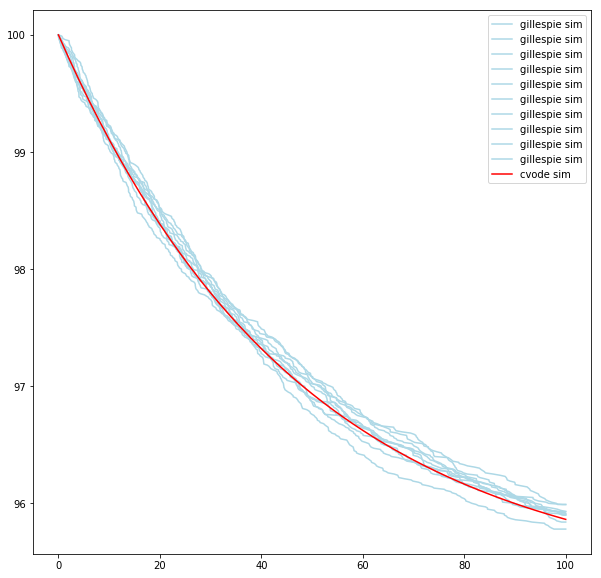

In [102]:
r = te.loada(model_backup)

    
#plt.close()
fig = plt.figure(figsize=(10,10))
r.resetToOrigin()
r.timeCourseSelections=['time','[A_c]']

for i in range(10):
    r.reset()    
    r.integrator = 'gillespie'
    result = r.simulate(0,100,1000)
    plt.plot(result[:,0],result[:,1:],color = 'lightblue',label='gillespie sim')
    
r.reset()
r.integrator='cvode'
result = r.simulate(0,100)   
plt.plot(result[:,0],result[:,1:],color = 'red',label='cvode sim')
      
plt.legend()
plt.show()